In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-26 06:24:32.104823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 06:24:32.104955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 06:24:32.243860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !pip install keras-cv

In [3]:
train_folder_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/'
# test_folder_path = '/kaggle/input/ai-generated-images-vs-real-images/'

In [4]:
train_path = train_folder_path  +'train/'
val_path = train_folder_path + 'test/'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (32, 32)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             seed = 123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='binary')

Found 100000 files belonging to 2 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                                 shuffle=True,
                                                                 seed = 123,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='binary')

Found 20000 files belonging to 2 classes.


In [8]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [9]:
# !pip install keras-cv

In [10]:
# sharpness = keras_cv.layers.RandomSharpness(0.3)

In [11]:
# # Define the desired class index
# desired_class_index = 1  # Change this to the index of the desired class

# # Filter the dataset to include only images from the desired class
# train_dataset_filtered = train_dataset.map(lambda x, y: (x, y == desired_class_index)) \
#                                       .filter(lambda x, y: tf.reduce_all(y)) \
#                                       .map(lambda x, y: (x, desired_class_index))
# train_dataset_filtered

In [12]:
class_names = train_dataset.class_names

In [13]:
class_names

['FAKE', 'REAL']

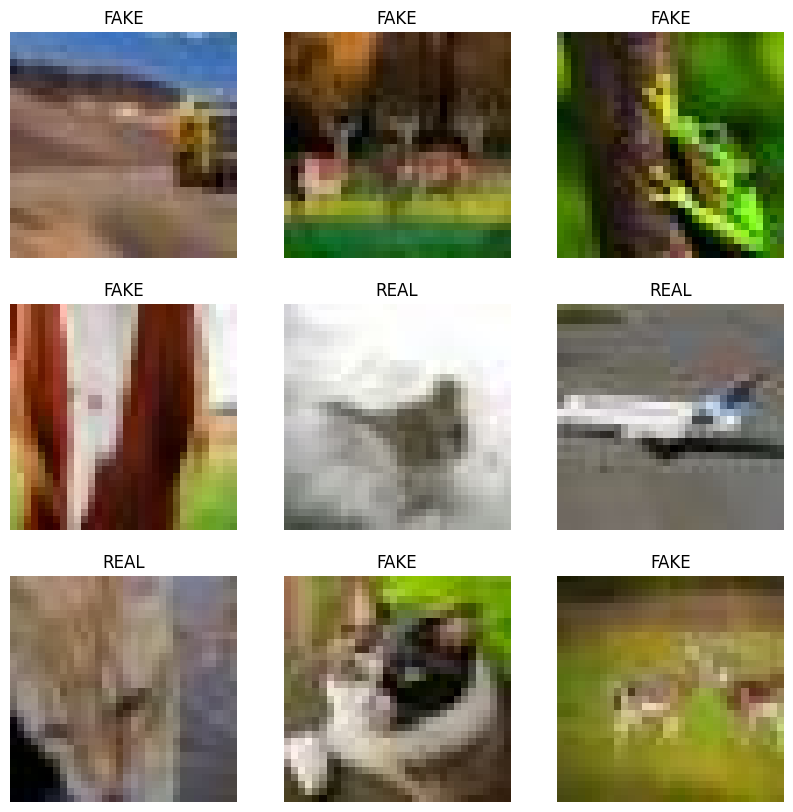

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Access the binary label directly
        label = labels[i].numpy()
        
        # Display the label
        plt.title("REAL" if label == 1 else "FAKE")
        plt.axis("off")

In [15]:
class_names = os.listdir(train_path)

In [16]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [17]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 500
Number of test batches: 125


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:

layers = []
layers.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
# First Convolutional Layer

layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))  
layers.append(tf.keras.layers.MaxPooling2D())
layers.append(tf.keras.layers.Dropout(0.25)) 

# Second Convolutional Layer
layers.append(tf.keras.layers.Conv2D(64, 3, activation='relu'))  
layers.append(tf.keras.layers.MaxPooling2D())
layers.append(tf.keras.layers.Dropout(0.25)) 

# Third Convolutional Layer
layers.append(tf.keras.layers.Conv2D(128, 3, activation='relu'))  
layers.append(tf.keras.layers.MaxPooling2D())
layers.append(tf.keras.layers.Dropout(0.25))


layers.append(tf.keras.layers.Flatten())


# ANN
layers.append(tf.keras.layers.Dense(64, activation='relu'))
layers.append(Dropout(rate=.4, seed=123))
layers.append(tf.keras.layers.Dense(32, activation ='relu'))
layers.append(Dropout(rate=.4, seed=123))
layers.append(tf.keras.layers.Dense(16, activation ='relu'))
layers.append(Dropout(rate=.4, seed=123))
layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

#Compile model
model = tf.keras.Sequential(layers)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', 'precision', 'recall'])

# Build the model so we can see a summary
model.build(input_shape=(None, 32, 32, 3))

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,705 (502.75 KB)

 Trainable params: 128,705 (502.75 KB)

 Non-trainable params: 0 (0.00 B)

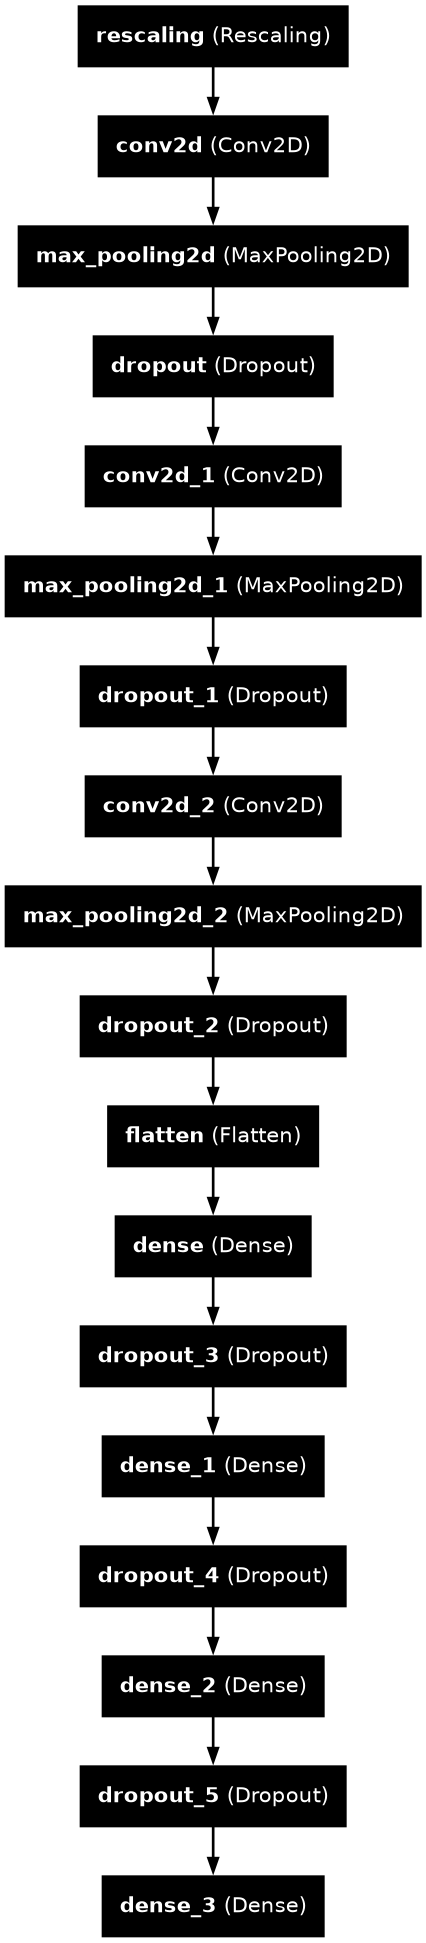

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False)

In [23]:
es = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1, patience=3, mode='auto'
)
# mc = ModelCheckpoint(
#     filepath='/content', 
#     monitor='val_accuracy', 
#     verbose=1, save_best_only=True
# )
lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    verbose=1, patience=2, min_lr=0.001
)

In [24]:
model.fit(train_dataset,   
                  epochs=10, 
                  callbacks=[es, lr],  
                  validation_data=validation_dataset,
#                   steps_per_epoch=200,
#                   validation_steps=200,
                 )

Epoch 1/10


2024-03-26 06:26:56.866597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1809: 6.57455, expected 5.77917
2024-03-26 06:26:56.866644: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1873: 6.94706, expected 6.15168
2024-03-26 06:26:56.866654: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1874: 6.59592, expected 5.80054
2024-03-26 06:26:56.866662: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1877: 6.39789, expected 5.60251
2024-03-26 06:26:56.866670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1950: 6.58588, expected 5.7905
2024-03-26 06:26:56.866677: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1970: 6.0549, expected 5.25952
2024-03-26 06:26:56.866685: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1982: 6.81896, expected 6.02358
2024-03-26 06:26:56.866693: E extern

   7/3125 ━━━━━━━━━━━━━━━━━━━━ 1:30 29ms/step - accuracy: 0.5130 - loss: 0.7121 - precision: 0.4002 - recall: 0.2224

I0000 00:00:1711434422.201232     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 146s 43ms/step - accuracy: 0.7356 - loss: 0.5266 - precision: 0.7270 - recall: 0.7341 - val_accuracy: 0.8691 - val_loss: 0.3091 - val_precision: 0.8786 - val_recall: 0.8560 - learning_rate: 0.0010
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.8563 - loss: 0.3537 - precision: 0.8620 - recall: 0.8458 - val_accuracy: 0.8842 - val_loss: 0.2796 - val_precision: 0.8685 - val_recall: 0.9051 - learning_rate: 0.0010
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8736 - loss: 0.3201 - precision: 0.8806 - recall: 0.8618 - val_accuracy: 0.8878 - val_loss: 0.2852 - val_precision: 0.8546 - val_recall: 0.9338 - learning_rate: 0.0010
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.8813 - loss: 0.3042 - precision: 0.8883 - recall: 0.8701 - val_accuracy: 0.8920 - val_loss: 0.2721 - val_precision: 0.8670 - val_recall: 0.9254 - learning_rate: 0.0010
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accu

Text(0.5, 1.0, 'loss')

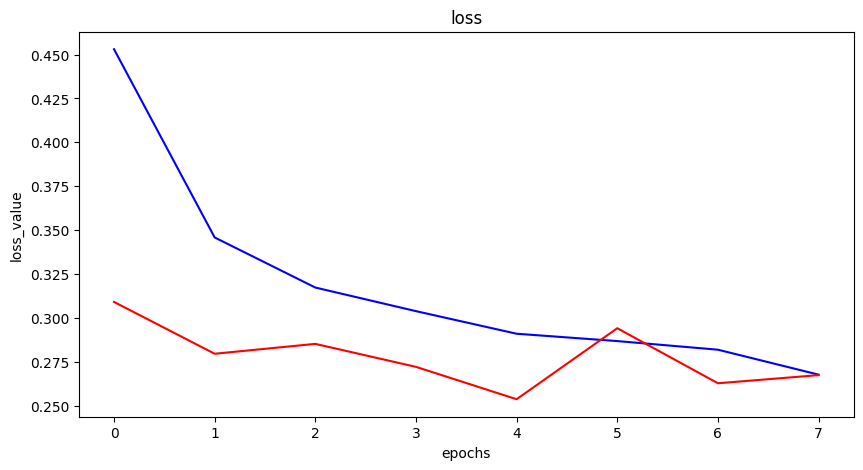

In [25]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['loss'], color='b', label='Training loss')
plt.plot(model.history.history['val_loss'], color='r', label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss_value")
plt.title("loss")

Text(0.5, 1.0, 'accuracy graph')

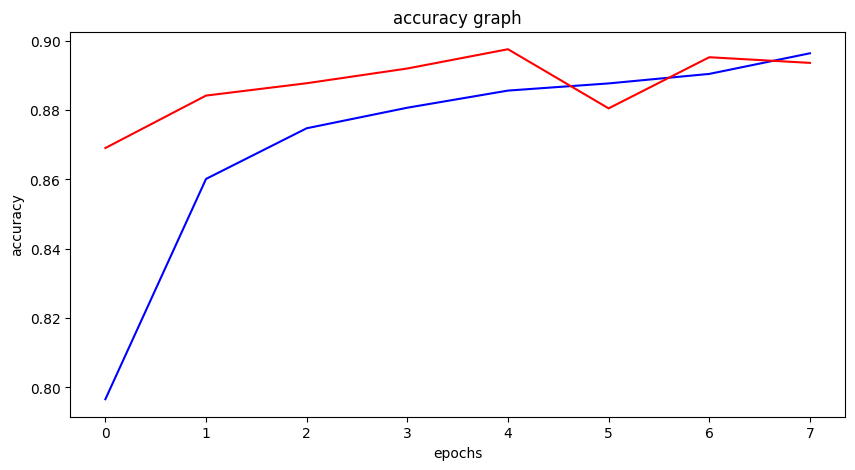

In [26]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy graph")

Text(0.5, 1.0, 'precision graph')

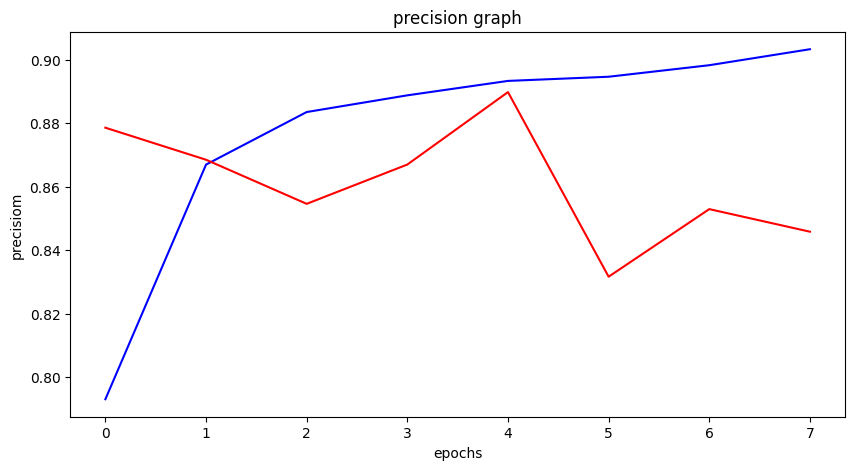

In [27]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['precision'],color='b',label='Training Precision')
plt.plot(model.history.history['val_precision'],color='r',label='Validation Precision')
plt.xlabel("epochs")
plt.ylabel("precisiom")
plt.title("precision graph")

Text(0.5, 1.0, 'recall graph')

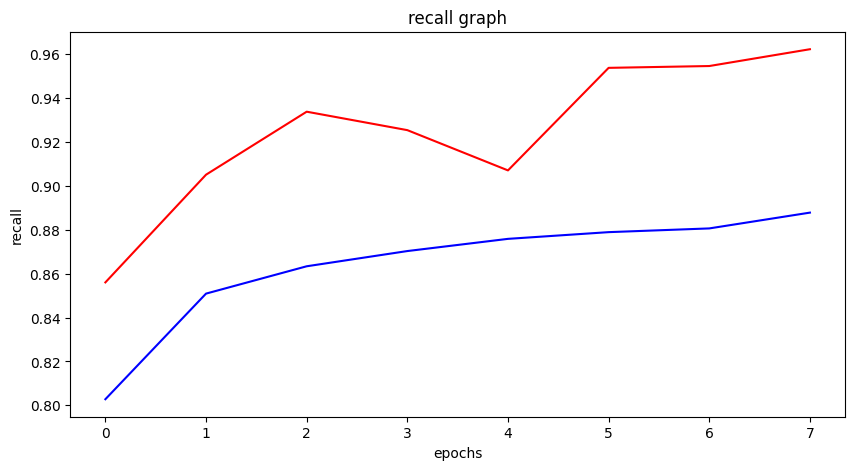

In [28]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['recall'],color='b',label='Training Recall')
plt.plot(model.history.history['val_recall'],color='r',label='Validation Recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.title("recall graph")

### Testing on test data

In [29]:
loss,accuracy,precision, recall = model.evaluate(test_dataset)
print(f'Test accuracy :{accuracy} \n loss:{loss} \n precision: {precision} \n recall:{recall}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8890 - loss: 0.2808 - precision: 0.8401 - recall: 0.9645
Test accuracy :0.8939999938011169 
 loss:0.26870211958885193 
 precision: 0.8454505801200867 
 recall:0.9656887054443359


### Loading images with prediciton label

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


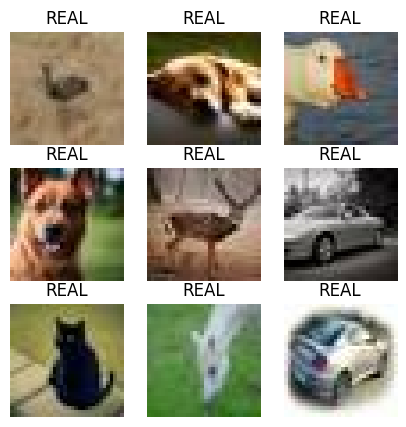

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")